In [1]:
from typing import TypedDict

from generalist.agents.core import CapabilityPlan
from generalist.tools.data_model import Attachments, ContentResource, ShortAnswer, Task


class ExecutionState(TypedDict):
    # what user is asking to do for them 
    ask: str
    # Identifies what the original question/task given, which objective it got transferred to, what the plan to get an answer is
    task: Task
    # order index of the step of the task's plan that is being executed 
    step: int
    # clues, findings and answers to the previous subtasks 
    context: str  
    # capability plan for this task (overwritten when a new subtask from the main plain is picked up)
    capability_plan: CapabilityPlan
    # capability plan step order 
    capability_plan_step: int
    # answers to subtask, the last one should be the final answer to the task 
    answers: list[ShortAnswer]
    # all files that might be needed to execute the task 
    attachments: list[Attachments]
    # all text resources that might be needed to execute the task
    resources: list[ContentResource]
    # tools that already got called
    # TODO: see if this is needed 
    tools_called: str  

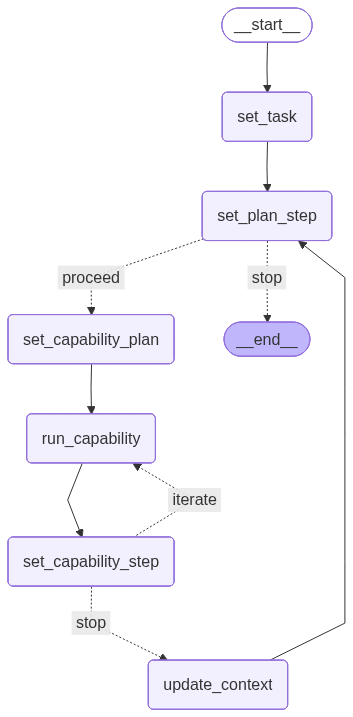

In [2]:
import json
from generalist.agents.core import AgentCapabilityDeepWebSearch, AgentCapabilityUnstructuredDataProcessor
from generalist.tools.planning import determine_capabilities, create_plan
from generalist.tools.summarisers import construct_short_answer
from langgraph.graph import StateGraph, START, END


workflow = StateGraph(state_schema=ExecutionState)

def init_state(ask: str, attachments: str = None, resources: str = None) -> ExecutionState:
    # TODO: should I be using LLM to convert attachments/resources to acceptable format?
    # TODO: implement proper handling of attachments and resources 
    return ExecutionState(
        ask=ask,
        task=None,
        step=None,
        context="",
        answers=list(),
        resources=list(),
        attachments=list(),
    )

def set_task(state: ExecutionState) -> ExecutionState: 
    question_task = state["ask"]
    task_plan_response = create_plan(question_task)

    result = json.loads(task_plan_response)
    task = Task(
      question=question_task,
      objective=result["objective"],
      plan=result["plan"],
    )
    state["task"] = task

    return state

def set_plan_step(state: ExecutionState) -> ExecutionState: 
    """  
    Determine which state is being executed. 
    """
    if state["step"] is None: 
        state["step"] = 0 
    else:
        state["step"] += 1
         
    return state

def check_plan_completion(state: ExecutionState) -> str:
    # FIXME: see what to do with the showrt_anser var, now only for debugging 
    short_answer = construct_short_answer(state["task"].objective, state["context"])
    print("\nCurrent answer is:\n", short_answer, "\n")
    # TODO: might incorporate early stopping if answer is found
    # if not short_answer | len(short_answer.answer) == 0 | short_answer.answer.lower() != "not found":
        
    plan_length = len(state["task"].plan)
    if state["step"] < plan_length:
        return "proceed"
    else:
        return "stop"

def set_capability_plan(state: ExecutionState) -> ExecutionState: 
    state["capability_plan"] = determine_capabilities(
        state["task"].plan[state["step"]], 
        task=state["task"], 
        attachments=state["attachments"], 
        context=state["context"]
    )
    state["capability_plan_step"] = 0

    return state

def set_capability_step(state: ExecutionState) -> ExecutionState:
    if state["capability_plan_step"] is None:
        state["capability_plan_step"] = 0 
    else:
        state["capability_plan_step"] += 1 

    return state

def check_capability_step(state:ExecutionState) -> ExecutionState: 
    capability_plan_length = len(state["capability_plan"].subplan)
    if state["capability_plan_step"] < capability_plan_length:
        # run the next capability step
        return "iterate"        
    else: 
        # signal that we need to move over to the next state
        return "stop" 

def run_capability(state: ExecutionState) -> ExecutionState: 
    capability_agent = state["capability_plan"].subplan[state["capability_plan_step"]]
    output = None
    match capability_agent:
        case AgentCapabilityDeepWebSearch():
            output = capability_agent.run()
        case AgentCapabilityUnstructuredDataProcessor():
            output = capability_agent.run(state["resources"])
        case _:
            print("DEBUG | run_capability | Call to unidentified agent: ", capability_agent)
    answers = output.answers
    resources = output.resources
    attachments = output.attachments 

    # FIXME: delete this  
    print("DEBUG | run_capability | Reponse output: ", output)

    if answers:
        state["answers"].extend(answers)
    if attachments:
        state["attachments"].extend(attachments)
    if resources:
        state["resources"].extend(resources)

    return state

def update_context(state: ExecutionState) -> ExecutionState:
    asked = state["task"].plan[state["step"]]
    found = state['answers']
    context_delta = "\n" + str(
        {
            "asked": asked,
            "found": found,
        }
    ) 
    state["context"] += context_delta

    # TODO: IMPORTANT need to save them somewhere else? 
    state["resources"] = list()
    return state

FILE_NAME_SAVED_STATE = "state.pkl"
def save_state(state: ExecutionState):
    import pickle
    
    with open(FILE_NAME_SAVED_STATE, "wb") as f:
        pickle.dump(state, f)

def load_state(path: str = FILE_NAME_SAVED_STATE) -> ExecutionState:
    import pickle

    with open(path, "rb") as f:
        return pickle.load(f)


workflow.add_node("set_task", set_task)
workflow.add_node("set_plan_step", set_plan_step)
workflow.add_node("set_capability_plan", set_capability_plan)
workflow.add_node("run_capability", run_capability)
workflow.add_node("set_capability_step", set_capability_step)
workflow.add_node("update_context", update_context)

workflow.add_edge(START, "set_task")
workflow.add_edge("set_task", "set_plan_step")
workflow.add_conditional_edges(
    "set_plan_step",
    check_plan_completion,
    {
        "proceed": "set_capability_plan",
        "stop": END,
    }
)
workflow.add_edge("set_capability_plan", "run_capability")
workflow.add_edge("run_capability", "set_capability_step")
workflow.add_conditional_edges(
    "set_capability_step", 
    check_capability_step,
    {
        "iterate":"run_capability",
        "stop": "update_context",
    }
)
workflow.add_edge("update_context", "set_plan_step")

generalist_graph = workflow.compile()

from IPython.display import Image, display
display(Image(generalist_graph.get_graph().draw_mermaid_png()))

In [3]:
# Test part nodes & logging
import logging

import mlflow

from generalist.models.core import MLFlowLLMWrapper
from generalist.utils import pprint
from generalist.tools import planning, web_search, text_processing

# STARTING TO LOG EVERYTHING (MANUALLY ADDED)
logging.getLogger().setLevel(logging.INFO)

mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
# MONKEY PATCH the llm call
planning.llm = MLFlowLLMWrapper(planning.llm) 
web_search.llm = MLFlowLLMWrapper(web_search.llm)
text_processing.llm = MLFlowLLMWrapper(text_processing.llm)

# FIXME: delete if if wanting to test at this stage
if False: 
        
    question = "Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M."
    initial_state = init_state(question)

    state = set_task(initial_state)
    pprint(state["task"].__str__())

In [4]:
# web_search.web_search(state["task"].question) 

In [5]:
raise InterruptedError

InterruptedError: 

In [ ]:
# Test 1
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)


question = "Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M."

initial_state = init_state(question)
final_state = generalist_graph.invoke(initial_state)

In [6]:
# Task 2 
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question = "How many at bats did the Yankee with the most walks in the 1977 regular season have that same season?"

initial_state = init_state(question)
final_state = generalist_graph.invoke(initial_state)

2025-09-07 18:12:46,257 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/show "HTTP/1.1 200 OK"
2025-09-07 18:13:02,048 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_create_plan at: http://localhost:5000/#/experiments/348793489932515010/runs/3c5485c66b354234bc2844f4498792ec
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010


2025-09-07 18:13:08,040 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


----------- construct_short_answer -----------  {
    "answer": "not found",
    "clarification": "The provided list does not contain any information regarding the number of at bats for a New York Yankees player in relation to walks during the 1977 regular season."
}

Current answer is:
 ShortAnswer(answer='not found', clarification='The provided list does not contain any information regarding the number of at bats for a New York Yankees player in relation to walks during the 1977 regular season.') 



2025-09-07 18:13:24,091 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/348793489932515010/runs/2829ad2f15c848abba752718e2eaa6bc
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010


2025-09-07 18:13:26,994 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_question_to_queries at: http://localhost:5000/#/experiments/348793489932515010/runs/0edc9561424947399cbbdccb28398da4
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010

Generated queries: ['Top walk leaders New York Yankees 1977 regular season', 'Walk leaders NY Yankees 1977']
!!!!!!!!!!!! search_url !!!!!!!!!! https://search.brave.com/search?q=Top+walk+leaders+New+York+Yankees+1977+regular+season
!!!!!!!!!!!! response_search !!!!!!!!!! b'<!doctype html>\n<html class="" lang="en-us">\n  <head>\n    <meta charset="utf-8" />\n    <link href="https://cdn.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://imgs.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://tiles.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://cdn.search.brave.com/serp/v3/_app/immutable/assets/inter-latin-wght-normal.C2S99t-D.woff2" crossorigin="anonymous" rel="preload" as="

2025-09-07 18:13:29,340 - httpx - INFO - HTTP Request: GET https://www.baseball-reference.com/teams/NYY/1977.shtml "HTTP/1.1 200 OK"


!!!!!!!!!!!! response_search !!!!!!!!!! b'<!doctype html>\n<html class="" lang="en-us">\n  <head>\n    <meta charset="utf-8" />\n    <link href="https://cdn.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://imgs.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://tiles.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://cdn.search.brave.com/serp/v3/_app/immutable/assets/inter-latin-wght-normal.C2S99t-D.woff2" crossorigin="anonymous" rel="preload" as="font" type="font/woff2" /> \n\t\t<link href="https://cdn.search.brave.com/serp/v3/_app/immutable/assets/app.Cye1icL-.css" rel="stylesheet"><!--[--><meta name="color-scheme" content=""/> <meta http-equiv="x-ua-compatible" content="IE=edge,chrome=1"/> <!--[!--><!--]--> <!--[--><meta name="robots" content="noindex,nofollow"/><!--]--> <meta name="description" content="Search the Web. Privately. Truly useful results, AI-powered answers, &amp; more. Al

2025-09-07 18:14:26,882 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/348793489932515010/runs/6428d54327684f83a644defdaa34e8fd
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010
:::::: chunk_response ::::::  The provided context does not contain specific data about walk leaders in 1977. Therefore, the relevant information is:

**NOT FOUND**


2025-09-07 18:15:37,732 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/348793489932515010/runs/535a5ae522774a0783dc61a426b18729
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010
:::::: chunk_response ::::::  Based on the provided context, there is no specific data about the top walk leaders in 1977. Therefore, the answer to your request is:

**NOT FOUND**


2025-09-07 18:15:48,982 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/348793489932515010/runs/5ab9144c7e1946c8963f77c55fe8cd3a
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010
:::::: chunk_response ::::::  NOT FOUND
DEBUG | run_capability | Reponse output:  AgentCapabilityOutput(answers=[], resources=None, attachments=None)


2025-09-07 18:15:55,195 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


----------- construct_short_answer -----------  {
    "answer": "not found",
    "clarification": "The provided list does not contain any data regarding the number of at bats for the New York Yankees player with the most walks in the 1977 regular season."
}

Current answer is:
 ShortAnswer(answer='not found', clarification='The provided list does not contain any data regarding the number of at bats for the New York Yankees player with the most walks in the 1977 regular season.') 



2025-09-07 18:16:10,783 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/348793489932515010/runs/244cf1248987476a8d521e6a120a60ec
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010


2025-09-07 18:16:13,666 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_question_to_queries at: http://localhost:5000/#/experiments/348793489932515010/runs/fbcf356ee42b4efc99ab1469ce6989da
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010

Generated queries: ['top walk leaders New York Yankees 1977 regular season', 'New York Yankees walks leader 1977']
!!!!!!!!!!!! search_url !!!!!!!!!! https://search.brave.com/search?q=top+walk+leaders+New+York+Yankees+1977+regular+season
!!!!!!!!!!!! response_search !!!!!!!!!! b'<!doctype html>\n<html class="" lang="en-us">\n  <head>\n    <meta charset="utf-8" />\n    <link href="https://cdn.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://imgs.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://tiles.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://cdn.search.brave.com/serp/v3/_app/immutable/assets/inter-latin-wght-normal.C2S99t-D.woff2" crossorigin="anonymous" rel="preload

2025-09-07 18:16:15,849 - httpx - INFO - HTTP Request: GET https://www.baseball-reference.com/teams/NYY/1977.shtml "HTTP/1.1 200 OK"


!!!!!!!!!!!! response_search !!!!!!!!!! b'<!doctype html>\n<html class="" lang="en-us">\n  <head>\n    <meta charset="utf-8" />\n    <link href="https://cdn.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://imgs.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://tiles.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://cdn.search.brave.com/serp/v3/_app/immutable/assets/inter-latin-wght-normal.C2S99t-D.woff2" crossorigin="anonymous" rel="preload" as="font" type="font/woff2" /> \n\t\t<link href="https://cdn.search.brave.com/serp/v3/_app/immutable/assets/app.Cye1icL-.css" rel="stylesheet"><!--[--><meta name="color-scheme" content=""/> <meta http-equiv="x-ua-compatible" content="IE=edge,chrome=1"/> <!--[!--><!--]--> <!--[--><meta name="robots" content="noindex,nofollow"/><!--]--> <meta name="description" content="Search the Web. Privately. Truly useful results, AI-powered answers, &amp; more. Al

2025-09-07 18:17:14,875 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/348793489932515010/runs/6c38ba5174734d1cb69cd18575f507b8
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010
:::::: chunk_response ::::::  NOT FOUND

The provided context does not contain specific walk (BB) data for individual players. The statistics listed do not include BB counts which would be necessary to identify the player with the highest number of walks.


2025-09-07 18:18:43,658 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/348793489932515010/runs/83692b3b6b11420491b3b0f8a6688fbe
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010
:::::: chunk_response ::::::  The player with the highest number of walks (BB) from the provided context is Mickey Rivers with 20 walks. However, it's worth noting that Cliff Johnson also has 20 walks, making them tied for the highest number of walks among the players listed. If we strictly follow the instruction to identify one player, either answer would technically be correct based on the information given, but since both have the same number:

Mickey Rivers * 28 CF: **20** BB
Cliff Johnson 29 DH: **20** BB

Since the task asks for a single player and both players have the highest number of walks tied at 20, either can be considered correct. For the sake of providing one answer:

Mickey Rivers * 28 CF with **20** BB


2025-09-07 18:18:55,795 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/348793489932515010/runs/e1087a8ca7d8455c8775811b3c209d8e
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010
:::::: chunk_response ::::::  NOT FOUND


2025-09-07 18:19:05,546 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


----------- construct_short_answer -----------  {
    "answer": "Mickey Rivers",
    "clarification": "Based on the provided list, Mickey Rivers has 20 walks, which is tied for the highest with Cliff Johnson. Since the task requires a single player to be identified and both have the same number of walks, one (in this case, Mickey Rivers) is selected as the answer."
}
DEBUG | run_capability | Reponse output:  AgentCapabilityOutput(answers=[ShortAnswer(answer='Mickey Rivers', clarification='Based on the provided list, Mickey Rivers has 20 walks, which is tied for the highest with Cliff Johnson. Since the task requires a single player to be identified and both have the same number of walks, one (in this case, Mickey Rivers) is selected as the answer.')], resources=None, attachments=None)


2025-09-07 18:19:12,481 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


----------- construct_short_answer -----------  {
    "answer": "not found",
    "clarification": "The provided list does not contain any information about the number of at bats for Mickey Rivers or any other player in the 1977 regular season."
}

Current answer is:
 ShortAnswer(answer='not found', clarification='The provided list does not contain any information about the number of at bats for Mickey Rivers or any other player in the 1977 regular season.') 



2025-09-07 18:19:30,288 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/348793489932515010/runs/15d26db363b144238051f9c0c752cc38
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010


2025-09-07 18:19:32,965 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_question_to_queries at: http://localhost:5000/#/experiments/348793489932515010/runs/dfe808ad14254ad597ddd412e67811d4
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010

Generated queries: ['Mickey Rivers at bats 1977', '1977 Mickey Rivers stats at bats']
!!!!!!!!!!!! search_url !!!!!!!!!! https://search.brave.com/search?q=Mickey+Rivers+at+bats+1977
!!!!!!!!!!!! response_search !!!!!!!!!! b'<!doctype html>\n<html class="" lang="en-us">\n  <head>\n    <meta charset="utf-8" />\n    <link href="https://cdn.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://imgs.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://tiles.search.brave.com" rel="preconnect" crossorigin="anonymous" />\n<link href="https://cdn.search.brave.com/serp/v3/_app/immutable/assets/inter-latin-wght-normal.C2S99t-D.woff2" crossorigin="anonymous" rel="preload" as="font" type="font/woff2" /> \n\t\t<link href="https

2025-09-07 18:19:35,390 - httpx - INFO - HTTP Request: GET https://www.baseball-reference.com/players/r/rivermi01.shtml "HTTP/1.1 200 OK"


DEBUG | run_capability | Reponse output:  AgentCapabilityOutput(answers=None, resources=[ContentResource(provided_by='web_search', content="Mickey Rivers Stats, Height, Weight, Position, Rookie Status & More | Baseball-Reference.com Sports\xa0Reference\u202f® Baseball Football (college) Basketball (college) Hockey Soccer Blog Stathead\u202f® Immaculate Grid\u202f® Questions or Comments? Welcome ·\xa0 Your Account Logout Ad-Free Login Create Account MENU Players Teams Seasons Leaders Scores Playoffs Stathead Newsletter Full Site Menu Below You are here: BR Home Page > Major League Players > R Listing > Mickey Rivers Statistics and History Welcome ·\xa0 Your Account Logout Ad-Free Login Create Account Who are your favorite Guys of the 21st Century? Remember Some Guys with Immaculate Grid and Defector Mickey Rivers Position: Centerfielder Bats: Left • Throws: Left 5-10 ,\xa0 165lb \xa0(178cm,\xa074kg) Born: October 30 , 1948 in Miami, FL us Draft : Drafted by the Chicago White Sox in the 

2025-09-07 18:20:42,834 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/348793489932515010/runs/9adc4d06683c4ecfbd24a9771628f50f
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010
:::::: chunk_response ::::::  The number of at bats from the retrieved web content is **5629**.


2025-09-07 18:22:09,994 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/348793489932515010/runs/c2bffb5a7a544944a74f71c8bfb11722
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010
:::::: chunk_response ::::::  The number of at bats can be found in multiple entries throughout the context provided. However, since the task is to extract the number of at bats and there's no specific year or entry mentioned, here are several instances where the information is available:

- 1975: **672**
- 1976: **613**
- 1977: **594**
- 1978: **604**
- 1979 (NYY): **307**
- 1979 (TEX): **263**

Since the task did not specify a particular year, there is no single answer. The context provides multiple entries with at bats data over different years. If you need a specific entry's at bats number or further details, please provide additional instructions.


2025-09-07 18:22:27,341 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/348793489932515010/runs/be0f05062c5c4fdd9eb346bda02b7a17
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010
:::::: chunk_response ::::::  NOT FOUND


2025-09-07 18:22:32,498 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


----------- construct_short_answer -----------  {
    "answer": "5629",
    "clarification": "The number of at bats is explicitly stated as 5629 in the provided list."
}


2025-09-07 18:22:39,736 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


----------- construct_short_answer -----------  {
    "answer": "not found",
    "clarification": "The list provides multiple entries with at bats data for different years, but since no specific year was mentioned in the task, there is no single answer to extract."
}
DEBUG | run_capability | Reponse output:  AgentCapabilityOutput(answers=[ShortAnswer(answer='5629', clarification='The number of at bats is explicitly stated as 5629 in the provided list.'), ShortAnswer(answer='not found', clarification='The list provides multiple entries with at bats data for different years, but since no specific year was mentioned in the task, there is no single answer to extract.')], resources=None, attachments=None)


2025-09-07 18:22:49,333 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


----------- construct_short_answer -----------  {
    "answer": "5629",
    "clarification": "The number of at bats is explicitly stated as 5629 in the provided list, though it's unclear if this figure corresponds to Mickey Rivers specifically for the 1977 season or another year."
}

Current answer is:
 ShortAnswer(answer='5629', clarification="The number of at bats is explicitly stated as 5629 in the provided list, though it's unclear if this figure corresponds to Mickey Rivers specifically for the 1977 season or another year.") 



Trace(trace_id=fe803177d52c4a80a23770d4351211f6)